In [84]:
%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton, MouseEvent
import geoengine as ge
from geoengine.workflow_builder.operators import GdalSource, TemporalRasterAggregation, RasterStacker, RenameBands, \
    Expression,RasterTypeConversion, RasterBandDescriptor, Reprojection
import numpy as np
from typing import Tuple, Callable
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import xarray as xr

In [9]:
koeln_center_utm = [356766, 5644819]

In [10]:
ge.initialize("http://localhost:3030/api")

In [29]:
def _query_rectangle(*,
                     center: Tuple[float, float],
                     time: np.datetime64,
                     radius_px: float = 512) -> ge.QueryRectangle:
    resolution = ge.SpatialResolution(10, 10)
    bbox = ge.BoundingBox2D(
        xmin=center[0] - resolution.x_resolution * radius_px,
        xmax=center[0] + resolution.x_resolution * radius_px,
        ymin=center[1] - resolution.y_resolution * radius_px,
        ymax=center[1] + resolution.y_resolution * radius_px,
    )
    return ge.QueryRectangle(
        spatial_bounds=bbox,
        time_interval=ge.TimeInterval(time),
        srs='EPSG:32632',
        resolution=resolution,
    )

workflow = Reprojection(GdalSource("ndvi"), 'EPSG:32632')

workflow = ge.register_workflow(workflow)

query_rectangle = _query_rectangle(
        center=koeln_center_utm,
        time=np.datetime64("2014-06-01T00:00:00"),
        radius_px=512,
    )

data_array = await workflow.raster_stream_into_xarray(
    query_rectangle=query_rectangle,
    clip_to_query_rectangle=True,
    bands=[0], # TODO: improve for user, default = all? where are the band names?
)


/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


In [30]:
data_array

<xarray.DataArray (time: 1, band: 1, y: 1025, x: 1025)>
array([[[[171., 171., 171., ..., 197., 197., 197.],
         [171., 171., 171., ..., 197., 197., 197.],
         [171., 171., 171., ..., 197., 197., 197.],
         ...,
         [183., 183., 183., ..., 184., 184., 184.],
         [183., 183., 183., ..., 184., 184., 184.],
         [183., 183., 183., ..., 184., 184., 184.]]]])
Coordinates:
  * x            (x) float64 3.516e+05 3.517e+05 ... 3.619e+05 3.619e+05
  * y            (y) float64 5.65e+06 5.65e+06 5.65e+06 ... 5.64e+06 5.64e+06
  * time         (time) datetime64[ns] 2014-06-01
  * band         (band) int64 0
    spatial_ref  int64 0

In [80]:
str(data_array.rio.crs)

'EPSG:32632'

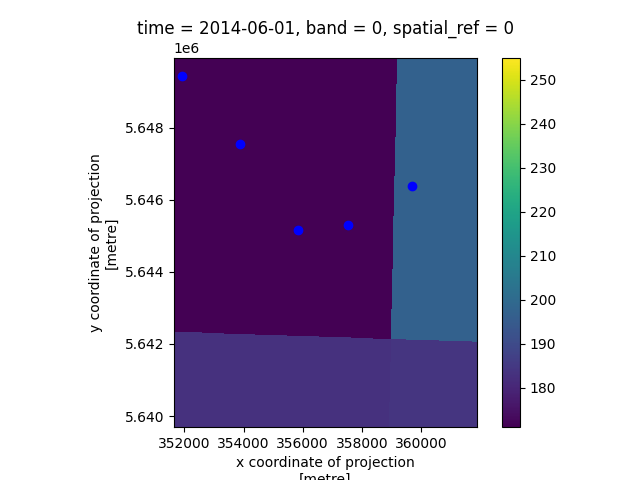

In [94]:
def points_by_drawing(filename: str, color: str, background: Callable[[plt.Axes], None]) -> None:

    try:
        points = gpd.read_file(filename)
    except:
        points = gpd.GeoDataFrame(crs=data_array.rio.crs, geometry=[])

    fig, ax = plt.subplots()

    background(ax)

    def on_click(event: MouseEvent):
        if event.button is not MouseButton.LEFT:
            return
        if not event.inaxes:
            return
        
        points.loc[len(points)] = [Point(event.xdata, event.ydata)]

        points.plot(ax=ax, c=color)

        points.to_file(filename)

    fig.canvas.mpl_connect('button_press_event', on_click)

    points.plot(ax=ax, c=color)


points_by_drawing(
    "foo.geojson",
    color="blue",
    background=lambda ax: data_array.isel(time=0, band=0).plot.imshow(vmax=255, ax=ax)
)

In [72]:
points

,geometry
0,POINT (355239.210 5644705.927)
1,POINT (359346.443 5640046.836)
2,POINT (360999.669 5644317.670)


In [50]:
points = gpd.GeoDataFrame(crs='EPSG:32632', geometry=[])

points.geometry = points.geometry.to_list() + [Point(355420.0318891963, 5640989.747483555)]

points

,geometry
0,POINT (355420.032 5640989.747)


In [48]:
points.geometry.to_list() + [Point(355420.0318891963, 5640989.747483555)]

[<POINT (355420.032 5640989.747)>]

In [ ]:
def on_click(event):
    if event.button is MouseButton.LEFT:
        print(event.xdata, event.ydata)

fig, ax = plt.subplots()

'''
data_array.isel(time=0).plot.imshow(
    rgb="band",
    vmax=4000,
    ax=ax,
)
'''

fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()